In [ ]:
!pip -q install opencv-python-headless scikit-image pandas matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/rust_detection")  # <-- klasörün buradaysa doğru
IMAGES_DIR = PROJECT_ROOT / "data" / "images"
MASKS_DIR  = PROJECT_ROOT / "data" / "masks"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("rust_defect.py exists:", (PROJECT_ROOT / "rust_defect.py").exists())
print("IMAGES_DIR exists:", IMAGES_DIR.exists(), IMAGES_DIR)
print("MASKS_DIR exists:", MASKS_DIR.exists(), MASKS_DIR)


PROJECT_ROOT: /content/drive/MyDrive/rust_detection
rust_defect.py exists: True
IMAGES_DIR exists: True /content/drive/MyDrive/rust_detection/data/images
MASKS_DIR exists: True /content/drive/MyDrive/rust_detection/data/masks


In [ ]:
import sys
sys.path.append(str(PROJECT_ROOT))

from rust_defect import AdvancedRustDetector, PANDAS_AVAILABLE
print("Imported AdvancedRustDetector. Pandas:", PANDAS_AVAILABLE)


Imported AdvancedRustDetector. Pandas: True


In [ ]:
detector = AdvancedRustDetector(
    cr_threshold=None,      # percentile
    cr_percentile=85.0,
    y_threshold=75,
    min_object_size=100,
    closing_kernel_size=7
)
print("Detector is ready.")


Detector is ready.


In [ ]:
from pathlib import Path

def find_gt_mask(image_name: str) -> Path | None:
    p1 = MASKS_DIR / image_name
    p2 = MASKS_DIR / f"{Path(image_name).stem}_mask.png"
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    return None

image_name = "099.png"  # <-- buraya istediğin dosyayı yaz
img_path = IMAGES_DIR / image_name
gt_path = find_gt_mask(image_name)

print("Image path:", img_path, "exists:", img_path.exists())
print("GT path:", gt_path, "exists:", (gt_path.exists() if gt_path else None))


Image path: /content/drive/MyDrive/rust_detection/data/images/099.png exists: True
GT path: /content/drive/MyDrive/rust_detection/data/masks/099_mask.png exists: True


In [ ]:
results = detector.process(img_path, gt_path)

print("Rust Ratio:", results["rust_ratio"])
print("Degradation Score:", results["degradation_score"])
print("Cr Threshold Used:", results["actual_cr_threshold"])

if results["evaluation_metrics"]:
    print("Evaluation Metrics:")
    for k, v in results["evaluation_metrics"].items():
        print(f"  {k}: {v:.4f}")
else:
    print("No GT metrics available.")


Rust Ratio: 4.335212707519531
Degradation Score: 4.335212707519531
Cr Threshold Used: 134.0
Evaluation Metrics:
  iou: 0.2424
  dice: 0.3902
  precision: 0.4144
  recall: 0.3687


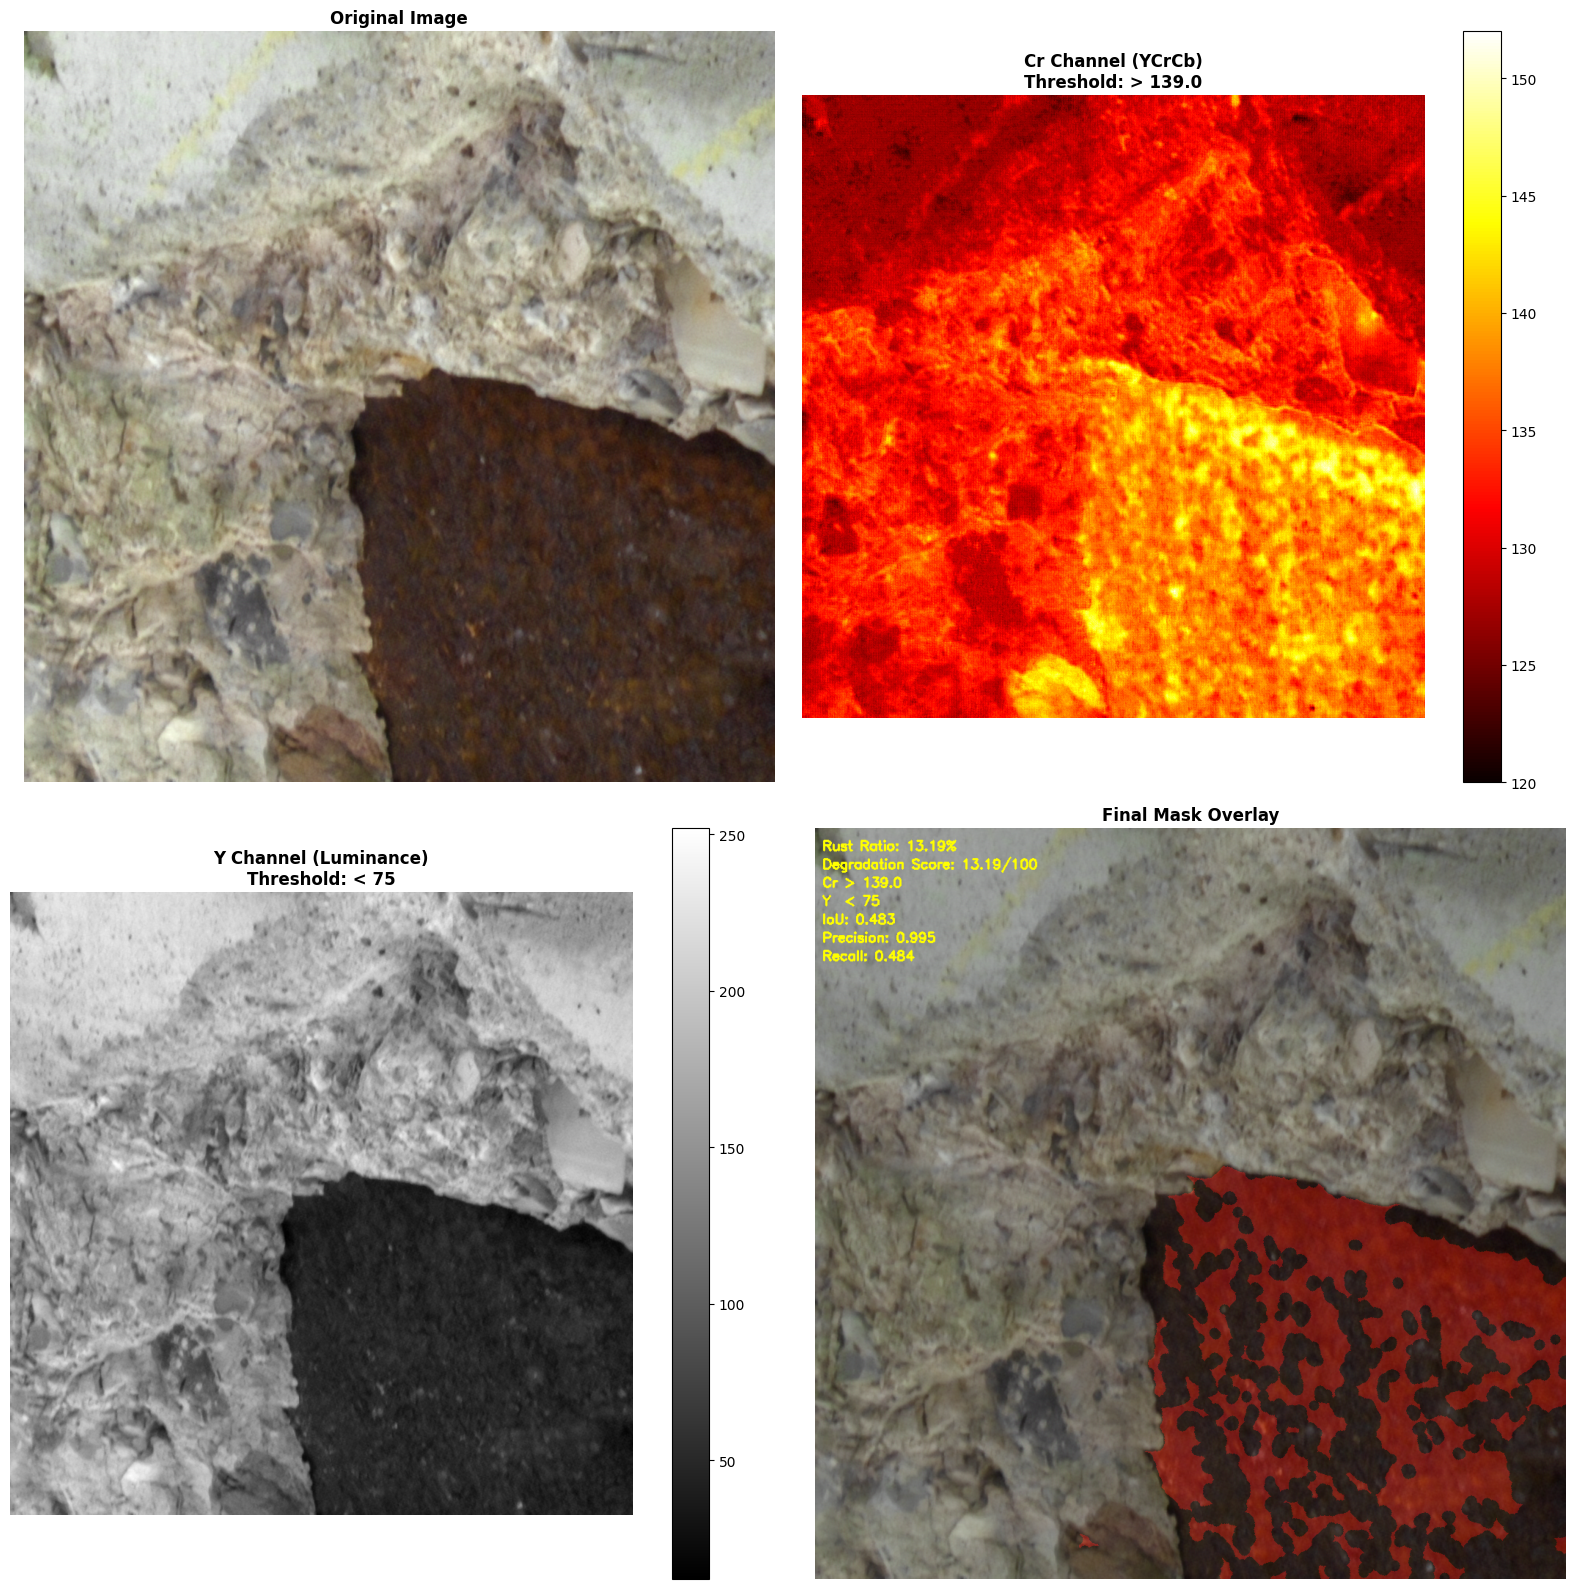

In [ ]:
detector.visualize(results)


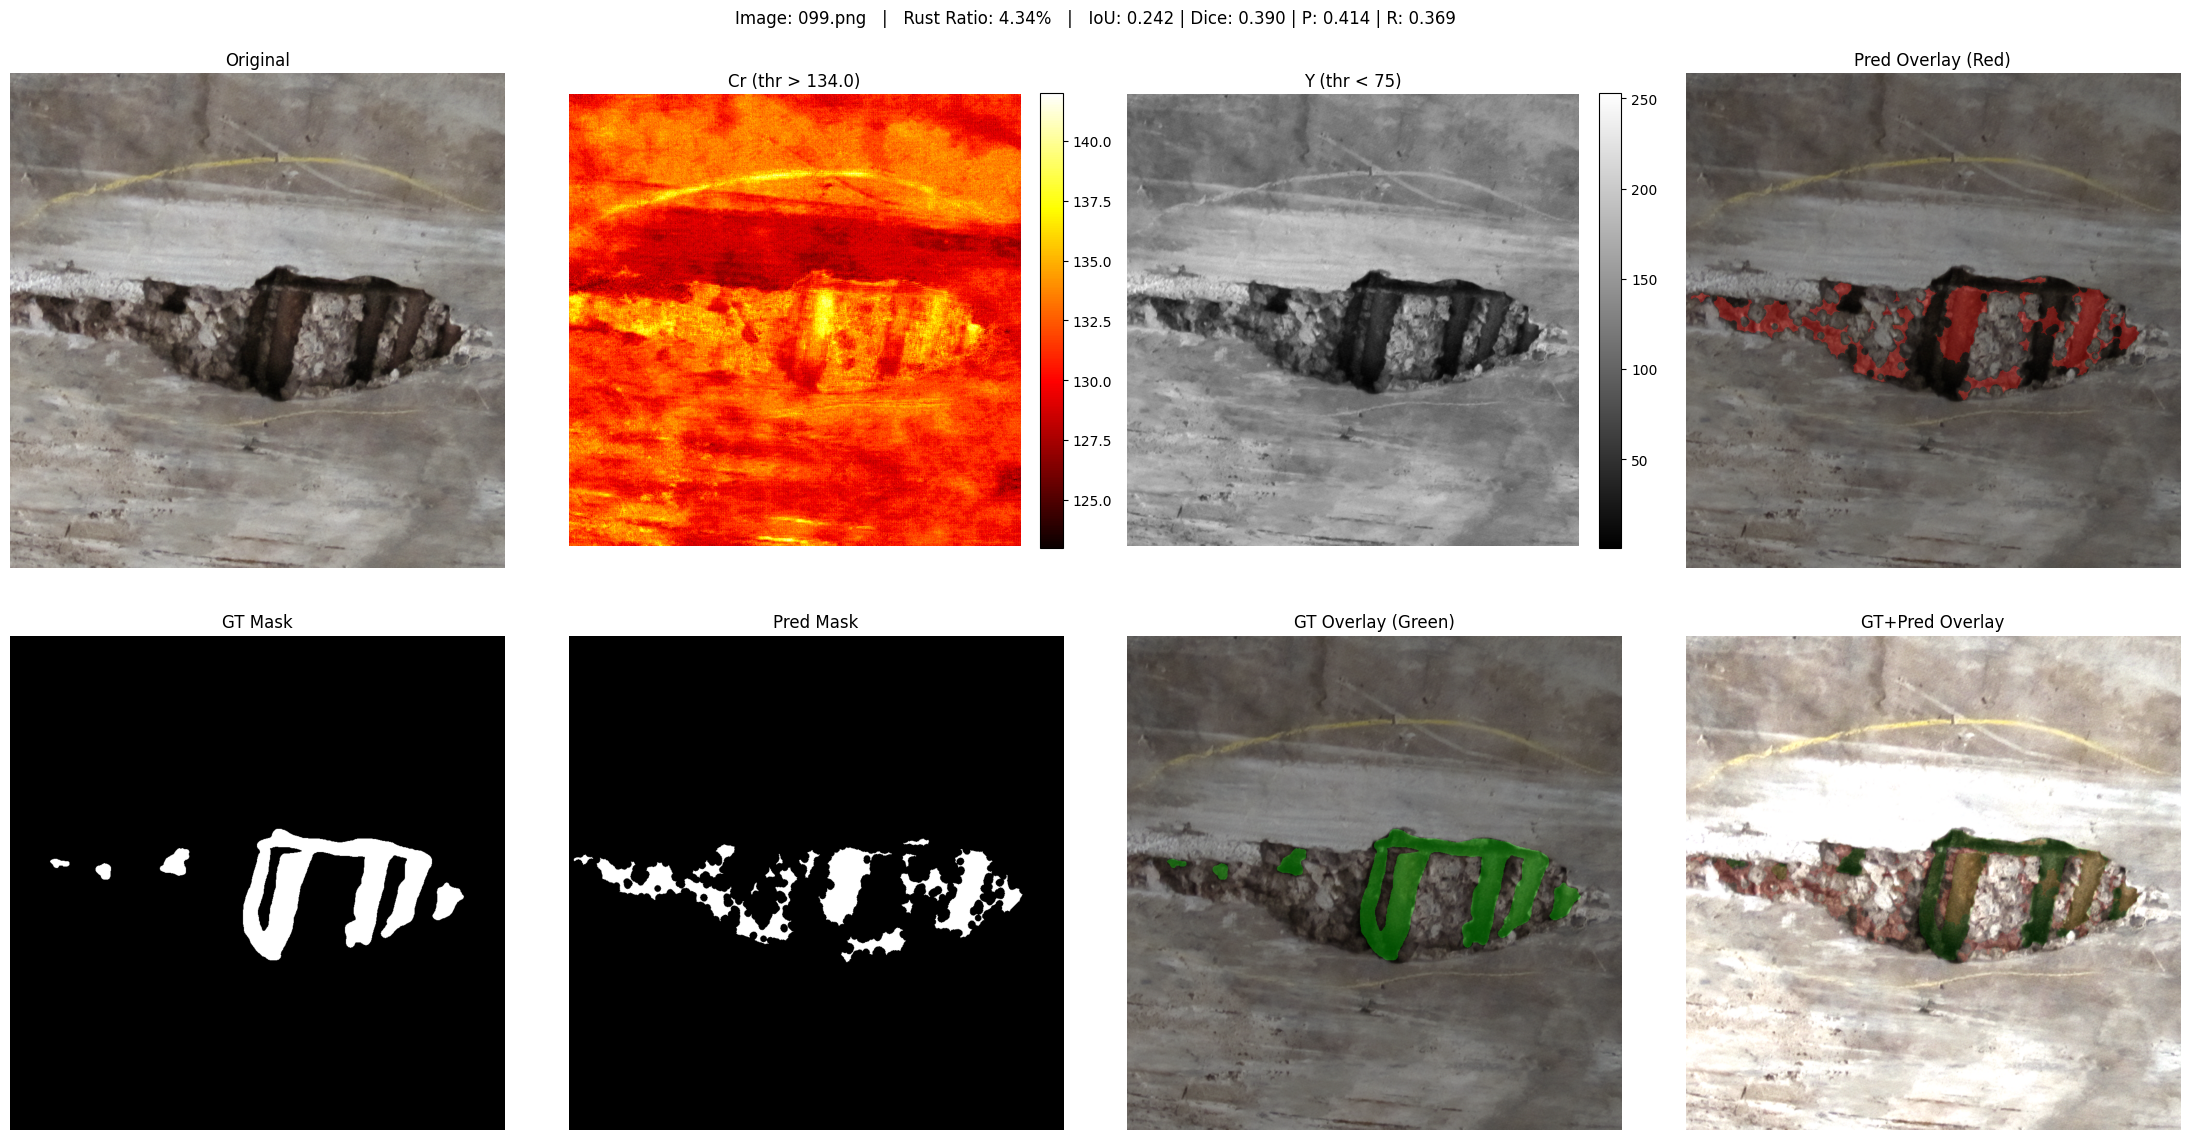

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

bgr = results["image"]
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

cr = results["cr_channel"]
y  = results["y_channel"]
pred = results["final_mask"]

gt = results.get("gt_mask", None)
metrics = results.get("evaluation_metrics", None)

if gt is not None:
    gt = (gt > 127).astype(np.uint8) * 255

# Pred overlay (red)
red_layer = np.zeros_like(rgb)
red_layer[pred > 0] = [255, 0, 0]
pred_overlay = cv2.addWeighted(rgb, 0.7, red_layer, 0.3, 0)

# GT overlay (green)
gt_overlay = np.zeros_like(rgb)
if gt is not None:
    green_layer = np.zeros_like(rgb)
    green_layer[gt > 0] = [0, 255, 0]
    gt_overlay = cv2.addWeighted(rgb, 0.7, green_layer, 0.3, 0)

fig, ax = plt.subplots(2, 4, figsize=(22, 12))

ax[0, 0].imshow(rgb); ax[0, 0].set_title("Original"); ax[0, 0].axis("off")

im1 = ax[0, 1].imshow(cr, cmap="hot")
ax[0, 1].set_title(f"Cr (thr > {results['actual_cr_threshold']:.1f})"); ax[0, 1].axis("off")
plt.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)

im2 = ax[0, 2].imshow(y, cmap="gray")
ax[0, 2].set_title(f"Y (thr < {detector.y_threshold})"); ax[0, 2].axis("off")
plt.colorbar(im2, ax=ax[0, 2], fraction=0.046, pad=0.04)

ax[0, 3].imshow(pred_overlay); ax[0, 3].set_title("Pred Overlay (Red)"); ax[0, 3].axis("off")

if gt is not None:
    ax[1, 0].imshow(gt, cmap="gray"); ax[1, 0].set_title("GT Mask"); ax[1, 0].axis("off")
else:
    ax[1, 0].imshow(np.zeros_like(pred), cmap="gray"); ax[1, 0].set_title("GT Not Found"); ax[1, 0].axis("off")

ax[1, 1].imshow(pred, cmap="gray"); ax[1, 1].set_title("Pred Mask"); ax[1, 1].axis("off")

if gt is not None:
    ax[1, 2].imshow(gt_overlay); ax[1, 2].set_title("GT Overlay (Green)"); ax[1, 2].axis("off")
else:
    ax[1, 2].imshow(rgb); ax[1, 2].set_title("GT Overlay (needs GT)"); ax[1, 2].axis("off")

# Optional: show both overlays combined (TP/FP/FN not included, just overlap)
combined = rgb.copy()
if gt is not None:
    combined = cv2.addWeighted(combined, 1.0, gt_overlay, 0.35, 0)
combined = cv2.addWeighted(combined, 1.0, pred_overlay, 0.35, 0)

ax[1, 3].imshow(combined); ax[1, 3].set_title("GT+Pred Overlay"); ax[1, 3].axis("off")

title_parts = [f"Image: {image_name}", f"Rust Ratio: {results['rust_ratio']:.2f}%"]
if metrics:
    title_parts.append(
        f"IoU: {metrics['iou']:.3f} | Dice: {metrics['dice']:.3f} | "
        f"P: {metrics['precision']:.3f} | R: {metrics['recall']:.3f}"
    )

fig.suptitle("   |   ".join(title_parts), fontsize=12)
plt.tight_layout()
plt.show()
